In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import datetime
from graphviz import Digraph
import time
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [80]:
df = pd.read_csv('/Users/kost/Desktop/решено/data/statistics-07-20.csv',sep=';',parse_dates=['operation_date'])
train_ops = pd.read_csv('/Users/kost/Desktop/решено/data/poezd.csv', sep=';', encoding='utf-8')
car_ops = pd.read_csv('/Users/kost/Desktop/решено/data/codes.csv',sep=';', encoding='utf-8')

In [83]:
ndf = df.sort_values(by=['operation_st_id','car_number','operation_date']).drop_duplicates().reset_index(drop=True)

### Первичный анализ датасета

In [10]:
operation_code = 2
print(train_ops[train_ops.index_code == operation_code].to_string(index=False))
print(car_ops[car_ops.index_code == operation_code].to_string(index=False))

 index_code mnem_code                                                         description
          2        От Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)
 index_code mnem_code                            description
          2      ОТПР ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         


In [11]:
# уникальные станции по операциям
df.operation_st_id.value_counts()

2,000,038,976.00    207099
2,000,038,600.00    146427
2,000,037,862.00    116936
2,001,933,494.00     96307
2,001,930,816.00     82794
                     ...  
2,000,037,640.00         1
2,000,036,452.00         1
2,000,036,458.00         1
2,000,035,312.00         1
2,000,036,334.00         1
Name: operation_st_id, Length: 744, dtype: int64

In [12]:
# уникальные вагоны по операциям
df.car_number.value_counts()

55864821    310
55822928    290
55927537    287
55626428    273
55701130    272
           ... 
60175320      1
95378899      1
29064912      1
57448243      1
60025954      1
Name: car_number, Length: 441248, dtype: int64

In [138]:
ndf.operation_date.min()

Timestamp('2020-07-01 00:00:00')

In [89]:
ndf.operation_date.max()

Timestamp('2020-07-31 23:59:00')

### Избавляемся от пропусков в operation_car

#### Всего операций с поездами в датасете

In [84]:
ndf.operation_car.unique()

array([ 3., 18.,  4., nan, 78., 20., 21., 80., 11., 81., 10., 28., 19.,
       79., 14., 29., 23., 26., 16., 27., 13.])

In [36]:
for i in ndf.operation_train[ndf.operation_train.notnull()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

5.0 ['Окончание формирования поезда']
4.0 ['Расформирование поезда']
2.0 ['Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)']
72.0 ['Отцепка вагонов']
62.0 ['Отпр. поезда со станции со сдачей на соседний участок']
71.0 ['Прицепка вагонов']
22.0 ['Отпр. поезда co станции со сдачей на другую дорогу']
44.0 ['Подача маршрута под грузовые операции']
42.0 ['Отпр. поезда со станции со сдачей на соседнее отделение']
30.0 ['Отпр. (просл.) поезда со станции "чужой" дороги в направл. "нашей" дороги']
64.0 ['Приб. пассажирского поезда на станцию назначения']
54.0 ['Прекращение "жизни" поезда 3-й категории']
35.0 ['Образование соединенного поезда']


#### Операции с поездом когда нет данных по операции с вагоном:

In [37]:
for i in ndf.operation_train[ndf.operation_car.isna()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

2.0 ['Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)']
62.0 ['Отпр. поезда со станции со сдачей на соседний участок']
22.0 ['Отпр. поезда co станции со сдачей на другую дорогу']
42.0 ['Отпр. поезда со станции со сдачей на соседнее отделение']


In [85]:
# все пропуски можно заменить операцией отправления
ndf.operation_car = ndf.operation_car.fillna(2)

In [69]:
print(f'{ndf.car_number.nunique() - ndf.car_number[ndf.operation_car == 2].nunique()} вагонов из датасета было не отправлено за рассматриваемый период')

128413 вагонов из датасета было не отправлено за рассматриваемый период


In [75]:
ndf.car_number[ndf.operation_car == 2].unique().shape

(312835,)

### Избавляемся от пропусков в danger

In [ ]:
ndf.danger = ndf.danger.fillna(0)

### Отрисовка графов последовательностей операций

In [92]:
def ops_tr_for_set_of_carts(cartsSet: set) -> pd.DataFrame:
    """
    Builds DF with historical data of changes in states from one operation to another for a set of carts IDs.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dataframe with following format (note that state changes are not unique)
        from 	to
    0 	3 	    4
    1 	4 	    3
    2 	3 	    4
    3 	4 	    3
    ...
    """
    stateChangeDF = pd.DataFrame(columns=['from', 'to'])
    iter = 0
    for cartID in tqdm(cartsSet):
        iter += 1
        opsListCart = list(ndf.operation_car[ndf.car_number == cartID])
        state_change = pd.DataFrame({'from': opsListCart[:-1], 'to': opsListCart[1:]})
        stateChangeDF = pd.concat(
            [stateChangeDF, state_change],
            axis=0,
            join="outer",
            ignore_index=True,
            keys=None,
            levels=None,
            names=None,
            verify_integrity=False,
            copy=True,
        )
    return stateChangeDF


def count_ops_transitions(cartsSet: set) -> dict:
    """
    Builds a dict with unique operation changes and state change frequency.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dict with unique operations and their quantity. See example below:
    {'3->4': 2, '4->3': 2, '3->2': 1, '2->80': 1}
    """
    sChangeList = []
    linksDict: dict = {}
    sChangeDF = ops_tr_for_set_of_carts(cartsSet)
    for i in range(sChangeDF.shape[0]):
        src = str(list(sChangeDF.loc[i])[0])
        trg = str(list(sChangeDF.loc[i])[1])
        sChangeList.append(src + "->" + trg)
    for entry in sChangeList:
        key = str(entry)
        if key in linksDict.keys():
            linksDict[key] += 1
        else:
            linksDict[key] = 1
    return linksDict

In [ ]:
ndf.operation_st_id.value_counts()

In [93]:
# cars
# carSet = {37843901}
# carSet = {94033792}

# stations
# option A - 
# carSet = set(ndf.car_number[ndf.operation_st_id == 2000038976])

# option B - drop all ops chains with less then 3
st = ndf.car_number[ndf.operation_st_id == 2001930816].value_counts()
carSet = set(st[st > 2].index)

In [94]:
sdict = count_ops_transitions(carSet)

DG = Digraph('finite_state_machine', filename='ops_fsm_rzd')
DG.attr(rankdir='LR', size='8,5')

for key in sdict:
    src = car_ops[car_ops.index_code == float(key.split('->')[0])].values[0][1]
    dst = car_ops[car_ops.index_code == float(key.split('->')[1])].values[0][1]
    DG.edge(src, dst, weight=str(sdict[key]), label=str(sdict[key]))

DG.view()

100%|██████████| 12640/12640 [01:44<00:00, 120.78it/s]


'ops_fsm_rzd.pdf'

### Анализ цепочек операций

### Выборка по станции. Словарь с последовательностями операций по вагонам

In [221]:
def extract_ops_chains(st_id: int) -> dict:
    cars = {}
    for i in tqdm(ndf.car_number[ndf.operation_st_id == st_id].unique()):
        cars[i] = str(ndf.operation_car[ndf.operation_st_id == st_id][ndf.car_number == i].values)
        cars[i] = cars[i][1:-1].strip().replace('\n','')
    return cars

In [224]:
cars = extract_ops_chains(2001930816)
cars

100%|██████████| 13178/13178 [02:29<00:00, 88.02it/s]


{28031961: '3. 80. 21.',
 28034106: '3. 80.',
 28036325: '3. 80.',
 28036507: '3. 80. 21.',
 28036838: '11. 81.  4.  2.',
 28044709: '3. 80. 21. 19. 81.  4.  4.  2.',
 28062347: '19.  4.',
 28063089: '19. 81.  4.  2.',
 28066819: '3. 80. 21. 81.  4.',
 28067726: '3. 80. 21.',
 28069235: '19. 81.  4.  2.',
 28077220: '19. 81.  4.  2.',
 28085678: '3. 80. 21.',
 28348928: '3. 80. 21. 19. 81.  4.  2.',
 28826360: '19. 81.  4.  4.  2.',
 28831469: '19. 81.  4.  2.  4.  2.',
 28834919: '19. 81.  4.  4.  2.',
 28836120: '3. 80. 21. 81.  4.',
 29002797: '11. 81.  4.',
 29014206: '19. 81.  4.  2.',
 29035763: '3. 80. 21.',
 29040995: '11. 81.  4.  2.',
 29068996: '11. 81.  4.  2.',
 29115599: '3. 80. 21. 19. 81.  4.  4.  2.',
 29140779: '19. 81.  4.  4.  4.  2.',
 29201399: '3. 80.',
 29228897: '11. 81.  4.  4.  4.  2.',
 29239498: '81.  4.  2.',
 29256294: '11. 81.  4.  2.',
 29262292: '3. 80.',
 29268497: '3. 80.',
 29274594: '3. 80. 21. 19. 81.  4.  4.  2.',
 29311594: '3. 80.',
 29313699: 

In [225]:
def sort_dict(dct: dict) -> dict:
    return dict(sorted(dct.items(), key=lambda item: item[1], reverse=True))

In [226]:
sort_dict(cars)

{54551502: '81.  4.  4.  4.  2.',
 52951373: '81.  4.  4.  2.  3. 80. 21. 19. 81.  4.  2.',
 62404413: '81.  4.  4.  2.  3. 80. 21.',
 50452838: '81.  4.  4.  2.  3. 80.',
 50174283: '81.  4.  4.  2.',
 50753250: '81.  4.  4.  2.',
 50761451: '81.  4.  4.  2.',
 51383024: '81.  4.  4.  2.',
 51818623: '81.  4.  4.  2.',
 52478641: '81.  4.  4.  2.',
 52834181: '81.  4.  4.  2.',
 52942232: '81.  4.  4.  2.',
 52943883: '81.  4.  4.  2.',
 52957925: '81.  4.  4.  2.',
 53053120: '81.  4.  4.  2.',
 53497608: '81.  4.  4.  2.',
 54562699: '81.  4.  4.  2.',
 54694427: '81.  4.  4.  2.',
 54758750: '81.  4.  4.  2.',
 55383095: '81.  4.  4.  2.',
 55587307: '81.  4.  4.  2.',
 55720569: '81.  4.  4.  2.',
 55943492: '81.  4.  4.  2.',
 56061070: '81.  4.  4.  2.',
 56126444: '81.  4.  4.  2.',
 56131519: '81.  4.  4.  2.',
 56247406: '81.  4.  4.  2.',
 56374499: '81.  4.  4.  2.',
 56794233: '81.  4.  4.  2.',
 56893811: '81.  4.  4.  2.',
 57902025: '81.  4.  4.  2.',
 57912560: '81.  4

### Аггрегация вагонов по типовым последовательностям операций

In [203]:
def agg_by_val(dct: dict) -> dict:
    '''
    Aggregates cars numbers by operations chains
    '''
    res = {}
    for i, v in dct.items():
        res[v] = [i] if v not in res.keys() else res[v] + [i]
    return res

In [227]:
agg_by_val(sort_dict(cars))

{'81.  4.  4.  4.  2.': [54551502],
 '81.  4.  4.  2.  3. 80. 21. 19. 81.  4.  2.': [52951373],
 '81.  4.  4.  2.  3. 80. 21.': [62404413],
 '81.  4.  4.  2.  3. 80.': [50452838],
 '81.  4.  4.  2.': [50174283,
  50753250,
  50761451,
  51383024,
  51818623,
  52478641,
  52834181,
  52942232,
  52943883,
  52957925,
  53053120,
  53497608,
  54562699,
  54694427,
  54758750,
  55383095,
  55587307,
  55720569,
  55943492,
  56061070,
  56126444,
  56131519,
  56247406,
  56374499,
  56794233,
  56893811,
  57902025,
  57912560,
  57915167,
  58747072,
  59106450,
  59637249,
  59722769,
  60116068,
  60264520,
  60311586,
  60324654,
  60565728,
  60609013,
  60745437,
  61343539,
  61377263,
  61460432,
  61468674,
  61561312,
  61680658,
  62119789,
  62319611,
  62875588,
  63362438,
  67084178,
  76719210,
  76719681,
  76719723,
  76772748],
 '81.  4.  2.  3. 80. 21.': [55197818],
 '81.  4.  2.  3. 80. 19. 81.  4.  2.': [60742889],
 '81.  4.  2.  3. 80.': [51457158, 51818516, 739

In [228]:
ocl = agg_by_val(sort_dict(cars))
for key in ocl:
    ocl[key] = len(ocl[key])
sort_dict(ocl)

{'3. 80. 21.': 2383,
 '3. 80. 21. 19. 81.  4.  2.': 1505,
 '3. 80. 21. 11. 81.  4.  2.': 1320,
 '11. 81.  4.  2.': 1090,
 '19. 81.  4.  2.': 677,
 '11. 81.  4.  4.  2.': 401,
 '3. 80. 21. 11.': 322,
 '3. 80. 21. 11. 81.  4.': 297,
 '3. 80. 21. 19. 81.  4.  2.  3. 80. 21.': 257,
 '3. 80. 21. 19. 81.  4.  4.  2.': 210,
 '11. 81.  4.': 202,
 '3. 80. 21. 19. 81.  4.  2.  3. 80. 21. 19. 81.  4.  2.': 192,
 '3. 80. 21. 11. 81.  4.  4.  2.': 188,
 '3. 80.': 178,
 '11. 81.  4.  4.  4.  2.': 178,
 '81.  4.  2.': 139,
 '3. 80. 21. 81.  4.': 138,
 '19. 81.  4.  2.  3. 80. 21. 19. 81.  4.  2.': 135,
 '19. 81.  4.  4.  2.': 118,
 '3. 80. 21.  4.  4.  2.': 114,
 '3. 80. 21. 19. 81.  4.  2.  3. 80. 21. 11. 81.  4.  2.': 102,
 '3. 80. 20.': 100,
 '11.': 98,
 '4. 2.': 96,
 '3. 80. 11. 81.  4.  4.  2.': 89,
 '19. 81.  4.  2.  3. 80. 21.': 89,
 '19. 81.  4.': 87,
 '3. 80. 11. 81.  4.  2.': 84,
 '3. 80. 21. 11. 81.  4.  4.  4.  2.': 60,
 '3. 80. 21. 11. 81.': 57,
 '3. 80. 19. 81.  4.  2.': 57,
 '81.  4.  

In [212]:
ops = '3. 80. 21. 19. 81.  4.  2.  3. 80. 21. 19. 81.  4.  4.  2. 19. 81.  4.  3. 80. 21. 19. 81.  4.  2.'
ops = list(map(float, ops.split()))
ops

[3.0,
 80.0,
 21.0,
 19.0,
 81.0,
 4.0,
 2.0,
 3.0,
 80.0,
 21.0,
 19.0,
 81.0,
 4.0,
 4.0,
 2.0,
 19.0,
 81.0,
 4.0,
 3.0,
 80.0,
 21.0,
 19.0,
 81.0,
 4.0,
 2.0]

In [213]:
for i in ops:
    print(car_ops[car_ops.index_code == i].values[0])

[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']
[21 'ВЫГ2' 'ВЫГРУЗКА НА ПП                        ']
[19 'ПГР9' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
[81 'УВПП' 'УБОРКА ВАГОНА С ПП                    ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']
[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']
[21 'ВЫГ2' 'ВЫГРУЗКА НА ПП                        ']
[19 'ПГР9' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
[81 'УВПП' 'УБОРКА ВАГОНА С ПП                    ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']
[19 'ПГР9' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
[81 'УВПП' 'УБОРКА ВАГОНА С ПП                    ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[8

## misc

### Профайлер

In [ ]:
## profiler code
# dt = datetime.datetime.now().strftime("%m/%d/%y - %H:%M")
# profile = ProfileReport(ndf, title=dt, explorative=True)
# fname = 'pd-report.html'
# profile.to_file(output_file=fname)

### Графики

<AxesSubplot:>

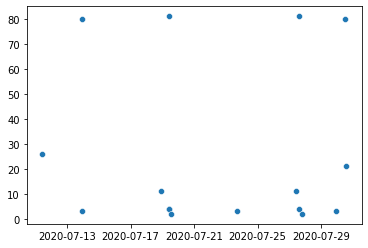

In [159]:
xxx = ndf[ndf.car_number == 52207693].sort_values(by='operation_date')[['operation_date','operation_car']].reset_index(drop=True)
# plt.scatter(xxx.operation_date.values,xxx.operation_car.values)
sns.scatterplot(x=xxx.operation_date.values,y=xxx.operation_car.values)